# Motivation

Let's reflect on our use of _accuracy_ to determine how good (or bad) our models perform:

Imagine we're training a classifier for a common condition, such as _hypertension_: Since about one in two people (at least in the _US_) suffers from _high blood pressure_, a **_balanced_** dataset containing 1000 observations would have about 500 _positive_ labels and 500 _negative_ labels. If we now say _everyone has high blood pressure_ we're correct half of the time - resulting in an accuracy of 50%. So far so good.

Let's repeat the same thought experiment with a rare disease, that only affects one in thousand people. If this distribution would be reflected in our data, it would result in a highly **_imbalanced_** dataset, containing 999 _negative_ and 1 _positive_ label. If we now say _nobody has this rare disease_ we reach an accuracy of 99.9% - amazing model performance, right? Intuitively, we know that predicting all labels as negative is not helpful for our _rare disease_-detection problem - and no hospital will buy our great model.

# Data Exploration And First Model

In this demo we'll be returning to our previous example: the _Breast Cancer Wisconsin_ dataset, containing features computed from a digitized image of a _fine needle aspirate_ (_FNA_) of breast mass, that we can use to predict whether a tissue sample is _malignant_ or _benign_.

We'll limit ourselves to a quick _EDA_ to refreshen our memory of the data we're working with.

N.B.: We're working with the _original_ dataset this time - the last one was slightly modified so we could learn how to handle missing values.

![](images/breast-cancer.png)

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('input/breast-cancer-prepared.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
data.sample(10, random_state=42)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,is_malignant
204,12.47,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373,...,24.64,96.05,677.9,0.14260,0.2378,0.2671,0.10150,0.3014,0.08750,0
70,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,0.1582,0.05461,...,26.58,165.90,1866.0,0.11930,0.2336,0.2687,0.17890,0.2551,0.06589,1
131,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,...,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019,1
431,12.40,17.68,81.47,467.8,0.10540,0.13160,0.07741,0.02799,0.1811,0.07102,...,22.91,89.61,515.8,0.14500,0.2629,0.2403,0.07370,0.2556,0.09359,0
540,11.54,14.44,74.65,402.9,0.09984,0.11200,0.06737,0.02594,0.1818,0.06782,...,19.68,78.78,457.8,0.13450,0.2118,0.1797,0.06918,0.2329,0.08134,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.8681,0.9387,0.26500,0.4087,0.12400,1
369,22.01,21.90,147.20,1482.0,0.10630,0.19540,0.24480,0.15010,0.1824,0.06140,...,25.80,195.00,2227.0,0.12940,0.3885,0.4756,0.24320,0.2741,0.08574,1
29,17.57,15.05,115.00,955.1,0.09847,0.11570,0.09875,0.07953,0.1739,0.06149,...,19.52,134.90,1227.0,0.12550,0.2812,0.2489,0.14560,0.2756,0.07919,1
81,13.34,15.86,86.49,520.0,0.10780,0.15350,0.11690,0.06987,0.1942,0.06902,...,23.19,96.66,614.9,0.15360,0.4791,0.4858,0.17080,0.3527,0.10160,0
477,13.90,16.62,88.97,599.4,0.06828,0.05319,0.02224,0.01339,0.1813,0.05536,...,21.80,101.20,718.9,0.09384,0.2006,0.1384,0.06222,0.2679,0.07698,0


Let's train a _decision tree_ model using a _train-test-split_ with _stratification_  - just like we did before:

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
X = data[data.columns[:-1]]
y = data['is_malignant']

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=33, stratify=y)

dt_model = DecisionTreeClassifier(random_state=33)
dt_model.fit(train_X, train_y)

pred_y = dt_model.predict(test_X)

accuracy_score = metrics.accuracy_score(test_y, pred_y)
print('Accuracy: {:.2%}'.format(accuracy_score))

Accuracy: 90.91%


# Evaluation And Metrics

We've reached approximately 91% accuracy, but does this really reflect how good our model performs considering our scenario - and the slight imbalance in our dataset, shown in the following output?

In [7]:
data['is_malignant'].value_counts()

0    357
1    212
Name: is_malignant, dtype: int64

<AxesSubplot:ylabel='is_malignant'>

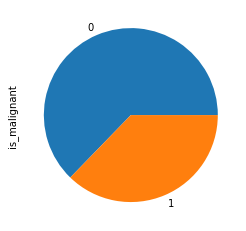

In [8]:
data['is_malignant'].value_counts().plot(kind='pie')

## _Confusion Matrix_

Ready to get confused? Before we start talking about alternative metrics, we need to take a look at some important vocabulary and concepts.

For this, we'll use our _real_ (or _true_) labels and the predicted _labels_ to create a **_confusion matrix_**: A table summarizing the count of correct and incorrect predictions broken down by each class.

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
cm = confusion_matrix(test_y, pred_y)
cm

array([[87,  3],
       [10, 43]])

Without further knowledge the output above will probably not make much sense to you. The following visualization should help:

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

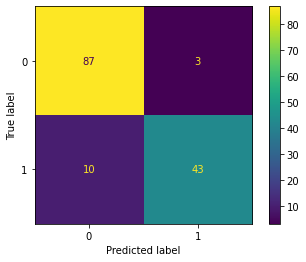

In [12]:
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()

To summarize the plot above:

* In 87 cases the tissue was _benign_ and was predicted as _benign_. This constitutes a **_True Negative_**.
* In 3 cases the tissue was _benign_ but was predicted as _malignant_. This constitutes a **_False Positive_**.
* In 10 cases the tissue was _malignant_ but was predicted as _benign_. This constitutes a **_False Negative_**.
* In 43 cases the tissue was _malignant_ and was predicted as _malignant_. This constitutes a **_True Positive_**.

Or in table form:

|||
|-|-|
|_True Negatives_|**_False Positive_**|
|**_False Negatives_**|_True Positives_|

Or in funny image form:

![](images/fp-fn.png)

## _Recall_

The (subjectively) worst case that can happen in our scenario is incorrectly classifying _malignant_ tissue as _not malignant_ - i.e. a _false negative_ - since it could lead to false security and no further examinations. The opposite - i.e. a _false positive_ - would be an unpleasant shock for the patient but could be cleared up by the doctors after further investigation.

What are other scenarios where _false negatives_ are considered worse (and _false positives_ consequently preferable)? Note that the following examples are subjective and arguable:

* We'd rather have a _false positive_ on a _COVID-19_-test and simply take another one to make sure, than having a _false negative_ and walk around infecting others.
* We'd rather have an airport metal detector go off wrongly, than people bringing dangerous items onto a flight.
* We'd rather perform multiple background checks on wrong suspects of terrorism, than not notice terroristic and threatening activies.

Luckily, there is a metric that helps us focus on identifying the positive cases by adding the number of _false negatives_ into the equation. _Recall_ describes the ability of a model to find all relevant cases within a dataset and is defined as follows:

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

Or in our scenario:

$$\text{Recall} = \frac{\text{Correctly Identified Malignant Tissue}}{\text{Correctly Identified Malignant Tissue} + \text{Tissue Incorrectly Labeled As Not Malignant}}$$

Let's calculate the _recall_ for our model by inserting the _true positives_ (43) and the _false negatives_ (10) into the formula:

In [13]:
recall = 43 / (43 + 10)
recall

0.8113207547169812

You can also use the built-in method from _scikit-learn_'s `metrics` module:

N.B.: In contrast to accuracy, the parameter order is important here!

In [14]:
metrics.recall_score(test_y, pred_y)

0.8113207547169812

## _Precision_

You probably noticed something about the formula: Why don't we simply label all tissue samples as _malignant_? With a _false negative_ count of 0 the _recall_ would obviously be 100%.

This is where another metric comes into play: _precision_, which expresses _relevancy_ of our prediction by answering the question, what proportion of positive identifications was actually correct. It is defined as follows:

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

Instead of _false negatives_ like we did in _recall_, we now focus on _false positives_. We can again find multiple real-world scenarios where _false positives_ are considered worse, like the following (subjective, again) examples:

* I'd rather receive some mails from _Nigerian princes_ or fishy online drug stores, than have my _spam filter_ wrongly remove potentially important mails.
* In criminal courts, it is generally considered preferable to reach a _false negative_ verdict, where a criminal is not found guilty, than convicting an innocent person - especially in countries that carry out capital punishment.

Applied to our scenario, we can rephrase the formula as follows:

$$\text{Precision} = \frac{\text{Correctly Identified Malignant Tissue}}{\text{Correctly Identified Malignant Tissue} + \text{Tissue Incorrectly Labeled As Malignant}}$$

With this metric we are focused on evaluating, if the tissue samples identified as _malignant_ were really _malignant_. This could be important, if the risk (or cost) of a follow-up examination would be very high.

If we insert our count of _true positives_ (43) and the count of _false positives_ (3) into the formula, we calculate the following precision:

In [15]:
precision = 43 / (43 + 3)
precision

0.9347826086956522

You can also use the built-in method from _scikit-learn_'s `metrics` module:

N.B.: Analogous to _recall_, the parameter order is important here!

In [16]:
metrics.precision_score(test_y, pred_y)

0.9347826086956522

## Relationship Between _Recall_ And _Precision_

Imagine we modify our model so that it is able to identify a single tissue sample correctly as _malignant_. We would achieve a _precision_ of 100% (since we have no _false positives_), but our _recall_ would be extremely low, because we failed to find more _malignant_ tumors (i.e. high number of _false negatives_). If we go to the other extreme and classify every tissue sample as _malignant_, we would have a _recall_ of 100%, but our _precision_ would be extremely low, and we would have to perform a lot of follow-up examinations. In other words, as we _increase_ _precision_, we _decrease recall_ - and vice versa.

In some cases - like the provided examples above or our main scenario, where wrong bad news and follow-up examinations are preferable to undetected disease - we can rather clearly decide which metric we can neglect.

However, in cases where we want an optimal blend of _precision_ and _recall_, we can use the _F1 score_, which is defined as the _harmonic mean_ of both metrics:

$$\text{F1 Score} = 2 * \frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$$

The _F1 score_ for our model would thus be:

In [17]:
f1_score = 2 * ((precision * recall)/(precision + recall))
f1_score

0.8686868686868686

We can - again - use the built-in method from _scikit-learn_'s `metrics` module:

In [18]:
metrics.f1_score(test_y, pred_y)

0.8686868686868686

# _Hold-Out_ Vs. _Cross-Validation_

Since we're at it, let's dive further into the topic of evaluation. Consider the following example:

In [19]:
X = data[data.columns[:-1]]
y = data['is_malignant']

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=52, stratify=y)

dt_model = DecisionTreeClassifier(random_state=52)
dt_model.fit(train_X, train_y)

pred_y = dt_model.predict(test_X)

print('Accuracy: {:.2%}'.format(metrics.accuracy_score(test_y, pred_y)))
print('Precision: {:.2%}'.format(metrics.precision_score(test_y, pred_y)))
print('Recall: {:.2%}'.format(metrics.recall_score(test_y, pred_y)))
print('F1 Score: {:.2%}'.format(metrics.f1_score(test_y, pred_y)))

Accuracy: 95.80%
Precision: 92.73%
Recall: 96.23%
F1 Score: 94.44%


What happened? Our model performs significantly better across (almost) all metrics we have covered so far. What changed?

While we did not tune any hyperparameters, the only thing we adjusted was the `random_state`-parameter that determined the split between the _train_- and _test_-set.

## _Hold-Out_ Method

What you saw above, is a common problem of the **_Hold-Out_**-method, where we split the whole dataset once and use one part (about 80%) for _learning_ while _holding out_ another part (about 20%) to see how the model performs on _unseen_ data. While being easy and fast to use, working reasonably well on huge datasets and being handy at providing a first indication of our model's performance, it comes with the problem of depending completely on how we split the data - as demonstrated above.

When we adjust our hyperparameters to perform optimally on this one _test-set_, we are risking _overfitting_ our model, since knowledge about the _test-set_ can _leak_ into the model which leads to our evaluation metrics no longer reporting on generalization performance.

![](images/train_test_val.png)

This problem is sometimes solved by splitting the whole data into three parts: one for _training_, one for _validation_ and one for _testing_. We then use the new **_validation set_** for tuning the hyperparameters, while further _holding-out_ the _test set_ for the final evaluation. The problem with this approach is, that it further reduces the number of observations we can use for training.

## _Cross-Validation_

**_Cross-validation_** or _k-fold cross-validation_ is the usually preferred alternative to the _hold-out_-method, since it allows us to teach and evaluate our model on multiple _splits_ instead of just one we're completely dependent on. For this, the dataset is split randomly into $k$ groups - or _folds_. After that a model is trained on all but one of the _folds_ and evaluated on the _unseen_ one. This is repeated until every _fold_ has been used for _validation_ once.

E.g. for _5-fold cross-validation_ the dataset is split into 5 groups and the model would be trained and evaluated 5 separate times so each _fold_ would get a chance to be the _validation_ set, as depicted in the table below:

|Split|Fold 1|Fold 2|Fold 3|Fold 4|Fold 5|
|-|-|-|-|-|-|
|1|**_Validation_**|_Train_|_Train_|_Train_|_Train_|
|2|_Train_|**_Validation_**|_Train_|_Train_|_Train_|
|3|_Train_|_Train_|**_Validation_**|_Train_|_Train_|
|4|_Train_|_Train_|_Train_|**_Validation_**|_Train_|
|5|_Train_|_Train_|_Train_|_Train_|**_Validation_**|

N.B.: Of course it still makes sense to _hold out_ a test set for final evaluation.

_scikit-learn_ offers us a handy way to perform _cross-validation_ using the method `cross_val_score`:

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
scores = cross_val_score(dt_model, X, y, scoring='accuracy', cv=5)
scores

array([0.9122807 , 0.90350877, 0.92982456, 0.93859649, 0.90265487])

As you see we get the score for every _fold_ - of course we can also calculate the _mean_:

In [22]:
scores.mean()

0.9173730787144854

We can also use other metrics by adjusting the `scoring`-parameter:

In [23]:
scores = cross_val_score(dt_model, X, y, scoring='recall', cv=5)
scores.mean()

0.9056478405315614

In [24]:
scores = cross_val_score(dt_model, X, y, scoring='f1', cv=5)
scores.mean()

0.8913916553308739

Or calculate all of them using a loop:

In [25]:
for curr_scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(dt_model, X, y, scoring=curr_scoring, cv=5)
    print('{}: {:.2%}'.format(curr_scoring, scores.mean()))

accuracy: 91.74%
precision: 87.93%
recall: 90.56%
f1: 89.14%


# _Random Forest_

In a real hospital, multiple doctors would take a look at the same samples and try to find a decision collectively. Each doctor would be looking at different aspects of the tissue, based on his/her experience or research focus. Some doctors would make their personal decisions based on the shape or smoothness, others by the size or symmetry of the potential tumor. In the end, the doctors would discuss or vote on how to proceed.

What we described here, is a great analogy for **_ensemble methods_** (also called _ensemble machine learning algorithms_), which use multiple learning algorithms to obtain better predictive performance. One such method is probably the most popular and widely used machine learning algorithm **_random forest_**.

Let's break apart its name:

* The **_forest_** consists of _multiple decision trees_, each of which comes up with a prediction. The predictions are then either averaged (for _regression_ tasks) or put up for a _majority vote_ (for _classification_ tasks).
* The **_random_**-_ness_ comes from each decision tree only using a _random subset of features_.

The following figure depicts both properties of a random forest:

![](images/random-forest.png)

While being slightly harder to interpret than a single decision tree, it generally performs better and reduces the risk of _overfitting_: The _voting_ (or _averaging_ in _regression_ tasks) process of many trees (100 by default!) compensates for the proneness of single trees to overfit.

## Training And Hyperparameters

As you probably expected, training and applying a _random forest model_ follows the same blueprint we're used to from previous algorithms:

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
X = data[data.columns[:-1]]
y = data['is_malignant']

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=33)

rf_model = RandomForestClassifier(random_state=33)
rf_model.fit(train_X, train_y)

pred_y = rf_model.predict(test_X)

accuracy_score = metrics.accuracy_score(pred_y, test_y)
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(test_y, pred_y)))
print('Precision: {:.2%}'.format(metrics.precision_score(test_y, pred_y)))
print('Recall: {:.2%}'.format(metrics.recall_score(test_y, pred_y)))
print('F1 Score: {:.2%}'.format(metrics.f1_score(test_y, pred_y)))

Accuracy: 95.80%
Precision: 96.15%
Recall: 92.59%
F1 Score: 94.34%


As you see, the random forest seems to perform better across all metrics we've covered so far. Of course we can also use cross-validation for a more sophisticated evaluation:

In [28]:
for curr_scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(rf_model, X, y, scoring=curr_scoring, cv=5)
    print('{}: {:.2%}'.format(curr_scoring, scores.mean()))

accuracy: 96.49%
precision: 97.11%
recall: 93.43%
f1: 95.19%


While we didn't need to adjust any _hyperparameters_ to achieve a better score, it's still important to know which adjustements we can make during the learning process. Since the forest is based on trees, we can specify the parameters we already got to know when training _decision trees_, such as:

* `max_depth`, denoting the maximum extent to which our trees can split. If the value is higher than the optimal value, the model will tend to overfit. But a low depth can hamper the training process.
* `min_samples_split`, indicating the minimum samples to be present in the nodes after they have split from the parent node.

Apart from that, we can control the number of trees in the forest using `n_estimators`, which is 100 by default. Try it out with a (much) higher value - does it improve the performance? What else do you notice?

## _Feature Importances_

A cool feature of _tree-based_ models we haven't covered so far, is measuring the _feature importance_ - i.e. determining which features are most useful for predicting a target variable.

For reaching this goal, we can use the attribute `feature_importances_`, containing the _impurity-based feature importances_: The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the _Gini importance_.

N.B.: Both _decision trees_ and _random forests_ contain this attribute. Since forests provide more information because of the number of trees, we're going to go with the latter.

In [29]:
X = data[data.columns[:-1]]
y = data['is_malignant']

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=33)

rf_model = RandomForestClassifier(random_state=33)
rf_model.fit(train_X, train_y)

rf_model.feature_importances_

array([0.07616975, 0.01254852, 0.03953921, 0.06519748, 0.00754734,
       0.01421261, 0.05260371, 0.09491522, 0.00224195, 0.0039692 ,
       0.01497696, 0.00323977, 0.01287356, 0.02554922, 0.00396013,
       0.00498574, 0.00752332, 0.00390774, 0.0034859 , 0.00473654,
       0.09483115, 0.0171474 , 0.10882753, 0.16562965, 0.01030784,
       0.00991405, 0.03731567, 0.08894089, 0.00710271, 0.00579924])

Since the list above is kind of meaningless, let's combine it with the feature names and sort it descendingly:

In [30]:
feature_importances = pd.Series(rf_model.feature_importances_, index=data.columns[:-1])
feature_importances.sort_values(ascending=False)

worst area                 0.165630
worst perimeter            0.108828
mean concave points        0.094915
worst radius               0.094831
worst concave points       0.088941
mean radius                0.076170
mean area                  0.065197
mean concavity             0.052604
mean perimeter             0.039539
worst concavity            0.037316
area error                 0.025549
worst texture              0.017147
radius error               0.014977
mean compactness           0.014213
perimeter error            0.012874
mean texture               0.012549
worst smoothness           0.010308
worst compactness          0.009914
mean smoothness            0.007547
concavity error            0.007523
worst symmetry             0.007103
worst fractal dimension    0.005799
compactness error          0.004986
fractal dimension error    0.004737
mean fractal dimension     0.003969
smoothness error           0.003960
concave points error       0.003908
symmetry error             0

Or plot the 5 most important features using the `plot`-method:

<AxesSubplot:>

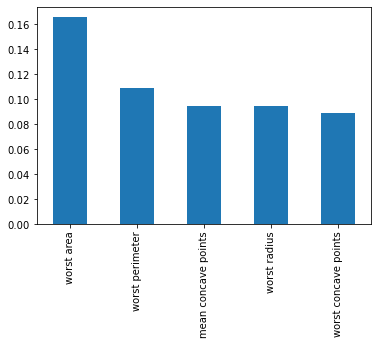

In [31]:
feature_importances.nlargest(5).plot(kind='bar')

As you see, we can not only use tree-based algorithms for prediction - it can also play an important role during data exploration!